<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Image-preliminaries" data-toc-modified-id="Image-preliminaries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Image preliminaries</a></span></li><li><span><a href="#Recreate-inpute" data-toc-modified-id="Recreate-inpute-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Recreate inpute</a></span></li><li><span><a href="#Recreate-style" data-toc-modified-id="Recreate-style-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Recreate style</a></span></li><li><span><a href="#Style-transfer" data-toc-modified-id="Style-transfer-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Style transfer</a></span></li></ul></div>

In [104]:
# Imports
from PIL import Image
from glob import glob
import numpy as np
import importlib
import vgg16_avg; importlib.reload(vgg16_avg)
from vgg16_avg import VGG16_Avg
from utils2 import limit_mem
import keras
import keras.backend as K
import scipy
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML
from matplotlib import animation, rc

In [2]:
limit_mem()

## Image preliminaries

In [4]:
# So where are my images
path = '/local/S.Rasp/fast.ai/train/'   # This contains all the category direcotires I assume
#path = '/project/meteo/scratch/S.Rasp/fast.ai/train/'

In [5]:
# Grab a random image
image_fns = sorted(glob(path + '*/*'))
len(image_fns)

19439

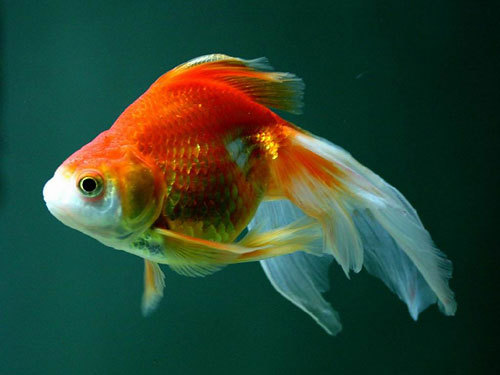

In [18]:
img = Image.open(image_fns[50]); img

In [19]:
imagenet_means = np.array([123.68, 116.779, 103.939], dtype=np.float32) # BGR

In [20]:
np.array(img).shape # --> channels last, but for now in RGB

(375, 500, 3)

In [28]:
# Write channel reverse function and subtract mean with lambda, huh
# Then add a dimension in the beginning --> batch_size = 1
preproc = lambda x: np.expand_dims((x - imagenet_means)[:, :, ::-1], 0)

In [31]:
img_arr = preproc(np.array(img))

In [32]:
img_arr.shape

(1, 375, 500, 3)

In [46]:
# Now the reverse function
deproc = lambda x, s: np.clip(x.reshape(s)[:, :, :, ::-1] + imagenet_means, 0, 255)

## Recreate inpute

In [3]:
# Load network, VGG16 with average pooling
vgg = VGG16_Avg(include_top=False)   # Do not include dense layers

/home/s/S.Rasp/repositories/courses/deeplearning2/vgg16_avg.py:48: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv1", padding="same")`
  x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1')(img_input)
/home/s/S.Rasp/repositories/courses/deeplearning2/vgg16_avg.py:49: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv2", padding="same")`
  x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2')(x)
/home/s/S.Rasp/repositories/courses/deeplearning2/vgg16_avg.py:53: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="block2_conv1", padding="same")`
  x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv1')(x)
/home/s/S.Rasp/repositories/courses/deeplearning2/vgg16_avg.py:54: UserWarning: Update your `Conv2D` c

In [24]:
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (AveragePooling2 (None, None, None, 128)   0         
__________

In [25]:
# Let's actually look at the activation of a certain layer for the image input
layer = vgg.get_layer('block4_conv1').output
layer   # This is a tensorflow tensor

<tf.Tensor 'block4_conv1/Relu:0' shape=(?, ?, ?, 512) dtype=float32>

In [26]:
vgg.input   # this as well. Which means we can build a model / graph from this

<tf.Tensor 'input_1:0' shape=(?, ?, ?, 3) dtype=float32>

In [27]:
inp2layer = keras.models.Model(vgg.input, layer)

In [12]:
inp2layer.summary()
# This is simply a part at the beginning of the full VGG

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (AveragePooling2 (None, None, None, 128)   0         
__________

In [35]:
targ = inp2layer.predict(img_arr)

In [36]:
targ.shape # [same, x, y, channels]

(1, 46, 62, 512)

In [57]:
class Evaluator(object):
    """f is a tensorflow function [image input, loss and gradients output]"""
    def __init__(self, f, shp):
        self.f, self.shp = f, shp
    
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)
    
    def grads(self, x):
        return self.grad_values.flatten().astype(np.float64)

In [58]:
# What is the loss --> mse between layer (which is the acts of some conv layer) and target
loss = K.mean(keras.metrics.mse(layer, targ))

# Lets get the tensors/graph for the gradients
grads = K.gradients(loss, vgg.input)

# Then get the function from the input to the loss and gradients
fn = K.function([vgg.input], [loss] + grads)

# And finally get the evaluator object
evaluator = Evaluator(fn, shp=img_arr.shape)

In [118]:
# Define the solver function
def solve_image(eval_obj, niter, x):
    orig_shape = x.shape
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(
            eval_obj.loss,   # Function to minimize, this is actually a python function! hence x
            x.flatten(),     # Initial guess
            fprime=eval_obj.grads,   # Gradient, see above, need the x
            maxfun=20,
        )
        x = np.clip(x, -127,127)   # I guess this might be really necessary
        print('Current loss:', min_val)
        # Save the image at an iteration
        imsave(f'{path}/results/res_at_iteration_{i}.png', deproc(x.copy(), orig_shape)[0])
    return x

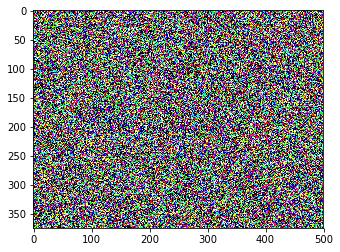

In [67]:
# Start out with a random image
rand_img = lambda s: np.random.uniform(-2.5, 2.5, s) / 100.
x = rand_img(img_arr.shape)
plt.imshow(x[0]);

In [71]:
x = solve_image(evaluator, 100, x)

Current loss: 3316.79516602


/home/s/S.Rasp/.conda/envs/cbrain_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  if sys.path[0] == '':


Current loss: 3303.12329102
Current loss: 3289.62597656
Current loss: 3240.67333984
Current loss: 3227.6159668
Current loss: 3214.85791016
Current loss: 3202.27661133
Current loss: 3189.87329102
Current loss: 3177.61181641
Current loss: 3165.56933594
Current loss: 3153.62988281
Current loss: 3141.90698242
Current loss: 2967.52026367
Current loss: 2930.39916992
Current loss: 2901.75634766
Current loss: 2879.22314453
Current loss: 2860.55493164
Current loss: 2844.48632812
Current loss: 2830.05517578
Current loss: 2816.76025391
Current loss: 2804.28540039
Current loss: 2792.43701172
Current loss: 2781.20214844
Current loss: 2673.27832031
Current loss: 2653.85253906
Current loss: 2638.6315918
Current loss: 2625.81323242
Current loss: 2580.79394531
Current loss: 2539.09179688
Current loss: 2529.63085938
Current loss: 2495.10107422
Current loss: 2478.87890625
Current loss: 2467.203125
Current loss: 2440.3671875
Current loss: 2428.35546875
Current loss: 2407.68554688
Current loss: 2396.400634

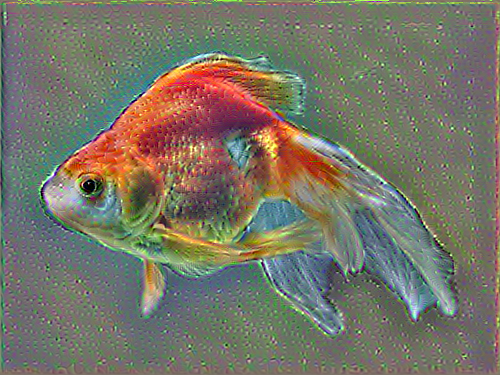

In [74]:
Image.open(path + 'results/res_at_iteration_99.png')

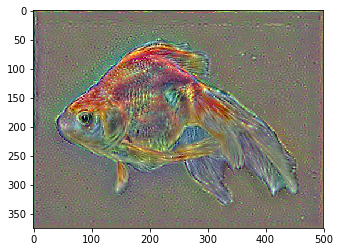

In [77]:
fig, ax = plt.subplots()
def animate(i): ax.imshow(Image.open(f'{path}results/res_at_iteration_{i}.png'))
anim = animation.FuncAnimation(fig, animate, frames=100, interval=50)
HTML(anim.to_html5_video())

## Recreate style

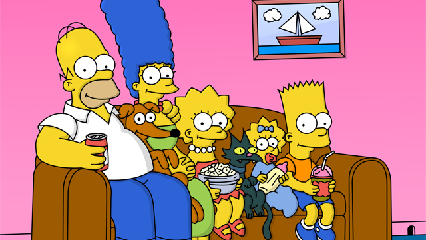

In [81]:
# First let's get an image
style = Image.open('/local/S.Rasp/fast.ai/style/the-simpsons.jpg')
style = style.resize(np.divide(style.size, 1.5).astype('int32'))
style

In [84]:
style_arr = preproc(np.array(style))
style_arr.shape

(1, 240, 426, 3)

In [87]:
# now new VGG
vgg = VGG16_Avg(include_top=False, input_shape=style_arr.shape[1:])   # Do not include dense layers
# Basically the same as before, but with a fixed size

/home/s/S.Rasp/repositories/courses/deeplearning2/vgg16_avg.py:48: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv1", padding="same")`
  x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1')(img_input)
/home/s/S.Rasp/repositories/courses/deeplearning2/vgg16_avg.py:49: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv2", padding="same")`
  x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2')(x)
/home/s/S.Rasp/repositories/courses/deeplearning2/vgg16_avg.py:53: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="block2_conv1", padding="same")`
  x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv1')(x)
/home/s/S.Rasp/repositories/courses/deeplearning2/vgg16_avg.py:54: UserWarning: Update your `Conv2D` c

In [86]:
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 240, 426, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 240, 426, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 240, 426, 64)      36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, 120, 213, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 120, 213, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 120, 213, 128)     147584    
_________________________________________________________________
block2_pool (AveragePooling2 (None, 60, 106, 128)      0         
__________

In [89]:
# Dictionary with name of layer and layer tensor
outputs = {l.name: l.output for l in vgg.layers}

In [91]:
# Pick some layers to compute loss function from
loss_layers = [outputs['block%i_conv1' % o] for o in range(1,3)]

In [92]:
loss_layers

[<tf.Tensor 'block1_conv1_2/Relu:0' shape=(?, 240, 426, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1_2/Relu:0' shape=(?, 120, 213, 128) dtype=float32>]

In [94]:
layers_model = keras.models.Model(vgg.input, loss_layers)
targs = [K.variable(o) for o in layers_model.predict(style_arr)]

In [95]:
# The activations for these layers
targs

[<tf.Variable 'Variable:0' shape=(1, 240, 426, 64) dtype=float32_ref>,
 <tf.Variable 'Variable_1:0' shape=(1, 120, 213, 128) dtype=float32_ref>]

In [96]:
# The key difference is the loss function
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

In [98]:
# The new loss
def style_loss(x, targ):
    return K.mean(keras.metrics.mse(gram_matrix(x), gram_matrix(targ)))

In [101]:
# The loss is then the sum for different layers
loss = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(loss_layers, targs))

In [103]:
# Minimize same as before
grads = K.gradients(loss, vgg.input)
style_fn = K.function([vgg.input], [loss] + grads)
evaluator = Evaluator(style_fn, style_arr.shape)

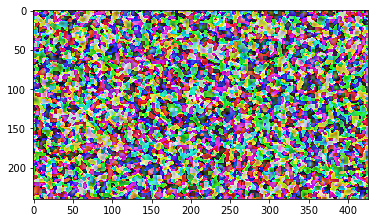

In [123]:
x = np.random.uniform(-2.5, 2.5,style_arr.shape) # Different. no divide by 100!?
x = scipy.ndimage.filters.gaussian_filter(x, [0, 2, 2, 0])
plt.imshow(x[0]);

In [124]:
x = solve_image(evaluator, 100, x)

Current loss: 109068.976562


/home/s/S.Rasp/.conda/envs/cbrain_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


Current loss: 99111.359375
Current loss: 90535.296875
Current loss: 83052.8515625
Current loss: 76573.25
Current loss: 70967.7109375
Current loss: 66075.015625
Current loss: 61743.2539062
Current loss: 57858.0898438
Current loss: 54334.890625
Current loss: 51118.9179688
Current loss: 48157.5078125
Current loss: 45408.0507812
Current loss: 42838.1015625
Current loss: 40446.484375
Current loss: 38189.234375
Current loss: 36243.1640625
Current loss: 35633.5039062
Current loss: 33574.5898438
Current loss: 33062.7148438
Current loss: 31138.1386719
Current loss: 29401.9140625
Current loss: 28906.5449219
Current loss: 28420.6152344
Current loss: 26613.9492188
Current loss: 26180.2695312
Current loss: 24482.03125
Current loss: 24081.7207031
Current loss: 22503.1152344
Current loss: 22131.7695312
Current loss: 20663.9042969
Current loss: 20320.765625
Current loss: 18968.8535156
Current loss: 18645.140625
Current loss: 17410.2128906
Current loss: 17105.6601562
Current loss: 16783.4785156
Current

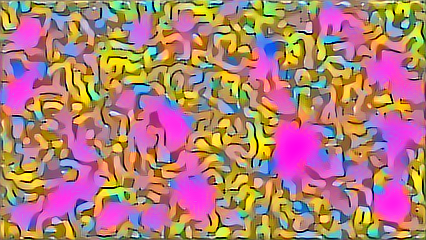

In [125]:
Image.open(path + 'results/res_at_iteration_99.png')

## Style transfer

In [127]:
# First we need to crop the image array to the shape of the style array!
w, h = style.size
w, h, img_arr.shape

(426, 240, (1, 375, 500, 3))

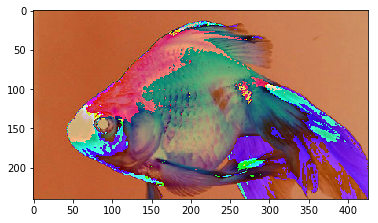

In [134]:
src = img_arr[:, 40:40+h, :w, :]
plt.imshow(src[0, :, :, ::-1])

In [135]:
# Get the models, first the style, this time 5 layers
style_layers = [outputs['block{}_conv2'.format(o)] for o in range(1, 6)]
style_model = keras.models.Model(vgg.input, style_layers)
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]

In [136]:
# Now the content
content_name = 'block4_conv2'
content_layer = outputs[content_name]
content_model = keras.models.Model(vgg.input, content_layer)
content_targ = K.variable(content_model.predict(src))

In [138]:
# Merge the two
# Weight for the different style layers
style_wgts = [0.05, 0.2, 0.2, 0.25, 0.3]
# loss from the style layers
loss = sum(style_loss(l1[0], l2[0]) * w for l1, l2, w in 
           zip(style_layers, style_targs, style_wgts))
# Add the loss for the content
loss += K.mean(keras.metrics.mse(content_layer, content_targ)) / 0.1   # This is the weightting between
# rest as before
grads = K.gradients(loss, vgg.input)
transfer_fn = K.function([vgg.input], [loss] + grads)

In [139]:
evaluator = Evaluator(transfer_fn, style_arr.shape)

In [143]:
x = np.random.uniform(-2.5, 2.5,style_arr.shape) # Different. no divide by 100!?

In [144]:
x = solve_image(evaluator, 100, x)

Current loss: 233491.9375


/home/s/S.Rasp/.conda/envs/cbrain_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


Current loss: 162390.6875
Current loss: 153661.03125
Current loss: 142054.609375
Current loss: 132455.015625
Current loss: 130655.6875
Current loss: 123293.40625
Current loss: 117469.234375
Current loss: 116159.625
Current loss: 110827.09375
Current loss: 109695.96875
Current loss: 105031.039062
Current loss: 104026.984375
Current loss: 99942.015625
Current loss: 99061.328125
Current loss: 98077.890625
Current loss: 97143.78125
Current loss: 96231.53125
Current loss: 95336.546875
Current loss: 94477.421875
Current loss: 93633.4765625
Current loss: 92815.515625
Current loss: 92012.140625
Current loss: 91238.0
Current loss: 90466.578125
Current loss: 89711.875
Current loss: 88977.765625
Current loss: 88249.796875
Current loss: 88073.265625
Current loss: 87292.734375
Current loss: 87127.265625
Current loss: 86351.90625
Current loss: 86193.5546875
Current loss: 85425.6171875
Current loss: 85273.7109375
Current loss: 84516.28125
Current loss: 84368.734375
Current loss: 83624.5625
Current lo

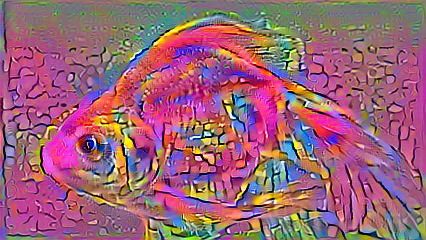

In [145]:
Image.open(path + 'results/res_at_iteration_99.png')